In [ ]:
import torch
import torchvision
import copy
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import time
from collections import Counter
import timm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision import models
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from torch.amp import autocast, GradScaler
from torchinfo import summary 


class AddNoise(object):
    def __init__(self, noise_level):
        self.noise_level = noise_level

    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)
        noise = torch.rand_like(img_tensor) * self.noise_level
        noisy_img = torch.clamp(img_tensor + noise, 0, 1)
        return noisy_img

SIZE = 256
COLOR_DEVIATION = 0.01
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=SIZE),
        AddNoise(0.01),
        transforms.ColorJitter(
            brightness=(1.0-COLOR_DEVIATION, 1.0+COLOR_DEVIATION),
            contrast=(1.0-COLOR_DEVIATION, 1.0+COLOR_DEVIATION),
            saturation=(1.0-COLOR_DEVIATION, 1.0+COLOR_DEVIATION),
            hue=(-COLOR_DEVIATION, COLOR_DEVIATION)
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

root = 'eyepac-light-v2-512-jpg/'
train_directory = root + 'train'
test_directory = root + 'test'
validation_directory = root + 'validation'

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'validation': datasets.ImageFolder(root=validation_directory, transform=image_transforms['validation']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

train_data_size = len(data['train'])
validation_data_size = len(data['validation'])
test_data_size = len(data['test'])

batch_size = 4

train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
validation_data = DataLoader(data['validation'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_data = DataLoader(data['test'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("Train class distribution:", Counter(data['train'].targets))
print("Validation class distribution:", Counter(data['validation'].targets))
print("Test class distribution:", Counter(data['test'].targets))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Train class distribution: Counter({0: 4000, 1: 4000})
Validation class distribution: Counter({0: 385, 1: 385})
Test class distribution: Counter({1: 385, 0: 365})
cuda:0


In [14]:
def get_model(model_name: str, show_arch: bool = True):
    match model_name:
        case "mobilenetv3-large":
            model_ft = models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.DEFAULT, progress=True)
            model_ft.classifier[-1] = nn.Linear(1280, 2)
        case "mobilenetv3-small":
            model_ft = models.mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.DEFAULT, progress=True)
            model_ft.classifier[-1] = nn.Linear(1024, 2)
        case "efficientnet-b0":
            model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1', progress=True)
            model_ft.classifier[-1] = nn.Linear(1280, 2)
        case "resnet18":
            model_ft = models.resnet18(weights='IMAGENET1K_V1', progress=True)
            model_ft.fc = nn.Linear(512, 2)
        case "efficientnet-b3":
            model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1', progress=True)
            model_ft.classifier[-1] = nn.Linear(1536, 2)
        case "squeezenet":
            model_ft = models.squeezenet1_0(weights='IMAGENET1K_V1', progress=True)
            model_ft.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
            model_ft.num_classes = 2
        case "densenet121":
            model_ft = models.densenet121(weights='IMAGENET1K_V1', progress=True)
            model_ft.classifier = nn.Linear(1024, 2)
        case "vit-tiny":
            model_ft = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
        case "convnext-tiny":
            model_ft = timm.create_model('convnext_tiny', pretrained=True, num_classes=2)
        case _:
            raise ValueError(f"Unknown model: {model_name}")
    if show_arch:
        print(summary(model_ft, input_size=(batch_size, 3, SIZE, SIZE)))
        for x, y in train_data:
            x = x.to(device)
            torch.onnx.export(model_ft, x, f=f'{model_name}.onnx')
            break
    return model_ft
get_model('squeezenet')

def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        print(f"Loaded checkpoint from {checkpoint_path}, resuming from epoch {start_epoch}")
        return start_epoch, best_acc
    else:
        print(f"No checkpoint found at {checkpoint_path}, starting from scratch")
        return 0, 0.0


def train_model(model, criterion, optimizer, scheduler, num_epochs=20, checkpoint_path=None):
    scaler = GradScaler('cuda')
    start_epoch, best_acc = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
    train_metrics = []
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(start_epoch, num_epochs):
        epoch_progress = tqdm(total=len(train_data), desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=False)

        for phase in ['train', 'validation']:
            running_loss = 0.0
            running_corrects = 0
            all_labels, all_preds = [], []

            model.train() if phase == 'train' else model.eval()
            dataloader = train_data if phase == 'train' else validation_data

            try:
                for inputs, labels in dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        with autocast('cuda'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    epoch_progress.set_postfix(phase=phase, 
                                              loss=running_loss/len(data[phase]), 
                                              acc=running_corrects/len(data[phase]))
                    epoch_progress.update()

            except RuntimeError as e:
                print(f"CUDA error during {phase}: {e}")
                torch.cuda.empty_cache()
                raise

            epoch_loss = running_loss / len(data[phase])
            epoch_acc = running_corrects / len(data[phase])
            epoch_f1 = f1_score(all_labels, all_preds, average='binary')
            epoch_auc = roc_auc_score(all_labels, all_preds)
            epoch_precision = precision_score(all_labels, all_preds, average='binary')
            epoch_recall = recall_score(all_labels, all_preds, average='binary')
            epoch_vram = torch.cuda.memory_allocated() / 1024**2
            
            if phase == 'train':
                scheduler.step(epoch_acc)

            train_metrics.append({
                'Phase': phase,
                'Epoch': epoch,
                'Loss': epoch_loss,
                'Acc': epoch_acc,
                'F1': epoch_f1,
                'AUC': epoch_auc,
                'Precision': epoch_precision,
                'Recall': epoch_recall,
                'VRAM': epoch_vram
            })

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} AUC: {epoch_auc:.4f}')

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_progress.close()

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc
        }, checkpoint_path)

    model.load_state_dict(best_model_wts)
    model.eval()
    test_corrects = 0
    all_labels, all_preds = [], []

    for inputs, labels in test_data:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            with autocast('cuda'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data).item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    test_acc = test_corrects / test_data_size
    test_f1 = f1_score(all_labels, all_preds, average='binary')
    test_auc = roc_auc_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_acc:.4f} F1: {test_f1:.4f} AUC: {test_auc:.4f}')

    return model, train_metrics, {'Test_Accuracy': test_acc, 'Test_F1': test_f1, 'Test_AUC': test_auc}

Layer (type:depth-idx)                   Output Shape              Param #
SqueezeNet                               [4, 2]                    --
├─Sequential: 1-1                        [4, 512, 15, 15]          --
│    └─Conv2d: 2-1                       [4, 96, 125, 125]         14,208
│    └─ReLU: 2-2                         [4, 96, 125, 125]         --
│    └─MaxPool2d: 2-3                    [4, 96, 62, 62]           --
│    └─Fire: 2-4                         [4, 128, 62, 62]          --
│    │    └─Conv2d: 3-1                  [4, 16, 62, 62]           1,552
│    │    └─ReLU: 3-2                    [4, 16, 62, 62]           --
│    │    └─Conv2d: 3-3                  [4, 64, 62, 62]           1,088
│    │    └─ReLU: 3-4                    [4, 64, 62, 62]           --
│    │    └─Conv2d: 3-5                  [4, 64, 62, 62]           9,280
│    │    └─ReLU: 3-6                    [4, 64, 62, 62]           --
│    └─Fire: 2-5                         [4, 128, 62, 62]          --
│ 

In [18]:
models_names = ["mobilenetv3-large", "mobilenetv3-small", "efficientnet-b0",
                "efficientnet-b3", "squeezenet", "vit-tiny", "convnext-tiny"]
results = pd.DataFrame(columns=['Model', 'Test_Accuracy', 'Test_F1', 'Test_AUC', 'Parameters', 'Training_Time', 'Peak_VRAM_MB', 'Speed'])


model_name = "squeezenet"
print(f'\nTraining {model_name}')
start_time = time.time()

batch_size = 1 if model_name in ["efficientnet-b3", "vit-tiny", "convnext-tiny", "densenet121"] else 2
train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
validation_data = DataLoader(data['validation'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_data = DataLoader(data['test'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

model_ft = get_model(model_name, False).to(device)
optimizer_ft = optim.Adam(model_ft.parameters(), 
                          lr=0.0003 if model_name in ["efficientnet-b3", "vit-tiny", "convnext-tiny", "densenet121"] 
                          else 0.0001 if model_name == "squeezenet" else 0.001)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.1, patience=2)

weights_path = f'{model_name}_weights.pth'
if os.path.exists(weights_path):
    state_dict = torch.load(weights_path, weights_only=False)
    model_ft.load_state_dict(state_dict)
    print(f"Loaded weights from {weights_path}")

checkpoint_path = f'{model_name}_checkpoint.pth'
total_params = sum(p.numel() for p in model_ft.parameters())
print(f"Total number of parameters: {total_params}")

torch.cuda.reset_peak_memory_stats()
try:
    model_ft, train_metrics, test_metrics = train_model(
        model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5, checkpoint_path=checkpoint_path
    )
except RuntimeError as e:
    print(f"Training failed for {model_name}: {e}")

model_ft.eval()
speed_start = time.time()
with torch.no_grad():
    for inputs, _ in test_data:
        inputs = inputs.to(device)
        model_ft(inputs)
speed = len(data['test']) / (time.time() - speed_start)

training_time = time.time() - start_time
peak_vram = torch.cuda.max_memory_allocated() / 1024**2
train_results = pd.DataFrame(data=train_metrics)
train_results.to_csv(f"{model_name}_train_metrics.csv", index=False)

results = pd.concat([results, pd.DataFrame([{
    'Model': model_name,
    'Test_Accuracy': test_metrics['Test_Accuracy'],
    'Test_F1': test_metrics['Test_F1'],
    'Test_AUC': test_metrics['Test_AUC'],
    'Parameters': total_params,
    'Training_Time': training_time,
    'Peak_VRAM_MB': peak_vram,
    'Speed': speed
}])], ignore_index=True)

print("\nModel Comparison:")
print(results.sort_values(by='Test_F1', ascending=False))


Training squeezenet
Total number of parameters: 736450
No checkpoint found at squeezenet_checkpoint.pth, starting from scratch


Epoch 1/5: 4009it [06:31, 22.12it/s, acc=0.0221, loss=0.0121, phase=validation]                            

train Loss: 0.5877 Acc: 0.6714 F1: 0.6753 AUC: 0.6714


validation Loss: 0.4789 Acc: 0.8221 F1: 0.7982 AUC: 0.8221


Epoch 2/5: 4010it [06:34, 23.90it/s, acc=0.026, loss=0.00141, phase=validation]                          

train Loss: 0.3551 Acc: 0.8549 F1: 0.8496 AUC: 0.8549


validation Loss: 0.5694 Acc: 0.7545 F1: 0.6802 AUC: 0.7545


Epoch 3/5: 4010it [06:32, 24.67it/s, acc=0.0221, loss=0.0101, phase=validation]                            

train Loss: 0.3023 Acc: 0.8786 F1: 0.8757 AUC: 0.8786


validation Loss: 0.2723 Acc: 0.9052 F1: 0.9056 AUC: 0.9052


Epoch 4/5: 4009it [06:51, 22.37it/s, acc=0.0208, loss=0.00579, phase=validation]                          

train Loss: 0.2778 Acc: 0.8899 F1: 0.8879 AUC: 0.8899


validation Loss: 0.2422 Acc: 0.9091 F1: 0.9107 AUC: 0.9091


Epoch 5/5: 4008it [06:33, 15.46it/s, acc=0.0221, loss=0.0066, phase=validation]                           

train Loss: 0.2544 Acc: 0.9012 F1: 0.8999 AUC: 0.9012


validation Loss: 0.2384 Acc: 0.9260 F1: 0.9270 AUC: 0.9260
Test Accuracy: 0.9053 F1: 0.9091 AUC: 0.9049

Model Comparison:
        Model  Test_Accuracy   Test_F1  Test_AUC Parameters  Training_Time  \
0  squeezenet       0.905333  0.909091  0.904875     736450    2023.405065   

   Peak_VRAM_MB       Speed  
0    159.748535  166.542473  


C:\Users\litvi\AppData\Local\Temp\ipykernel_10136\1850883969.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{


In [7]:
torch.save(model_ft.state_dict(), weights_path)
results.to_csv('model_comparison.csv', index=False) 

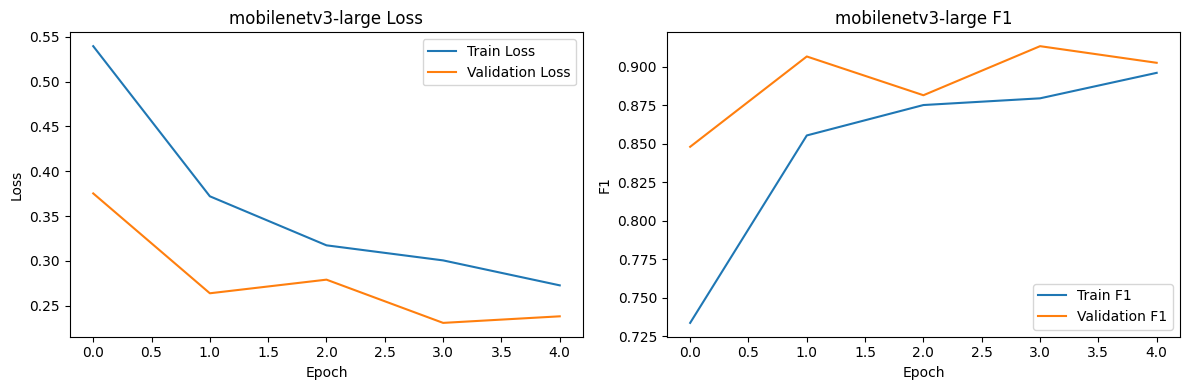

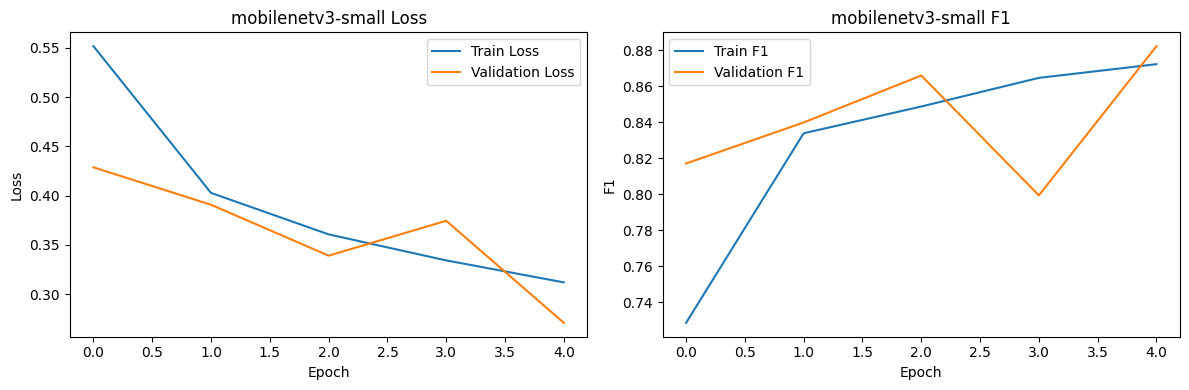

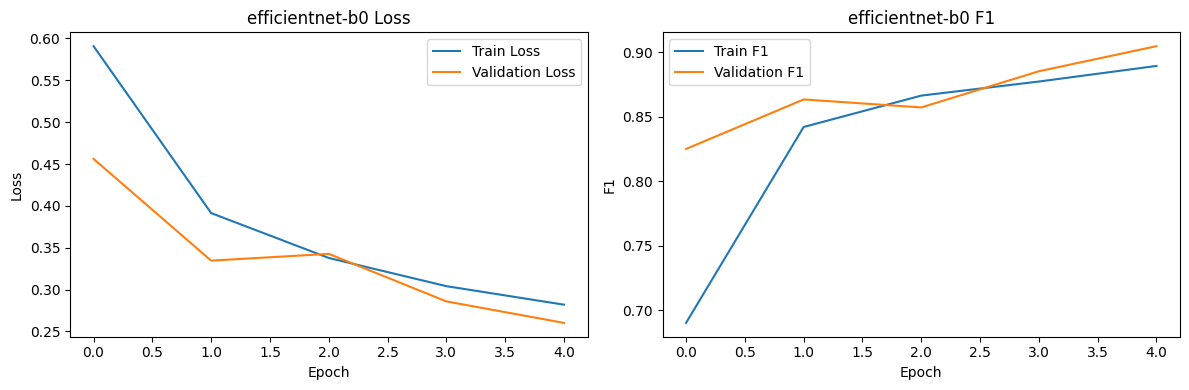

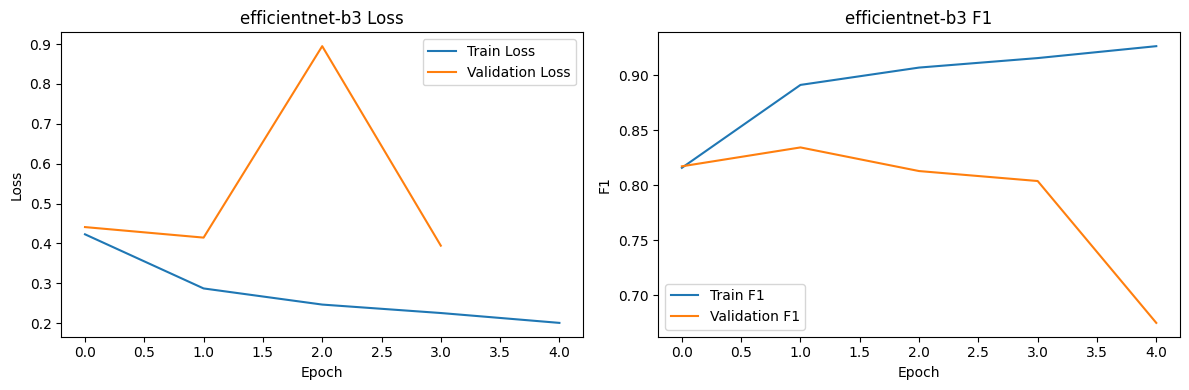

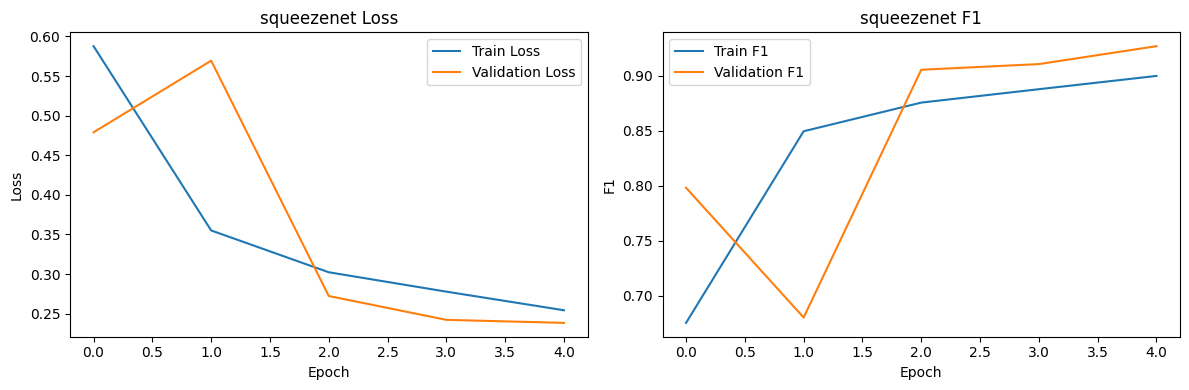

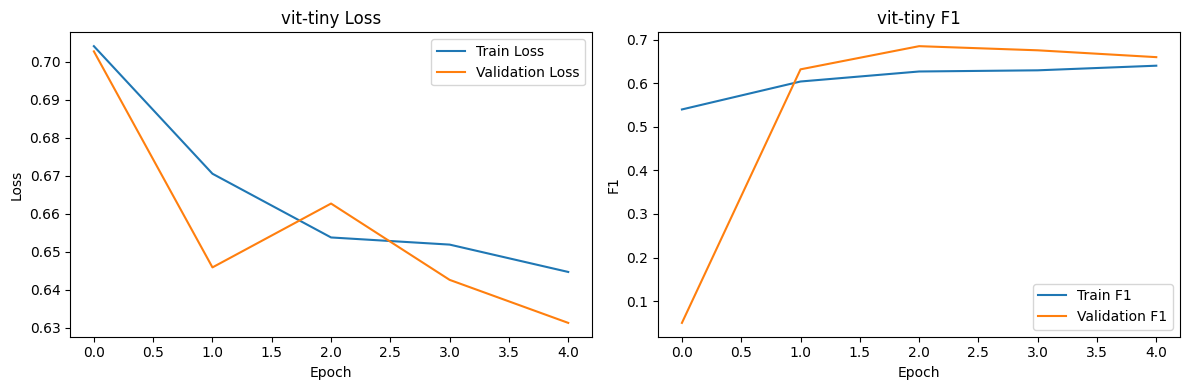

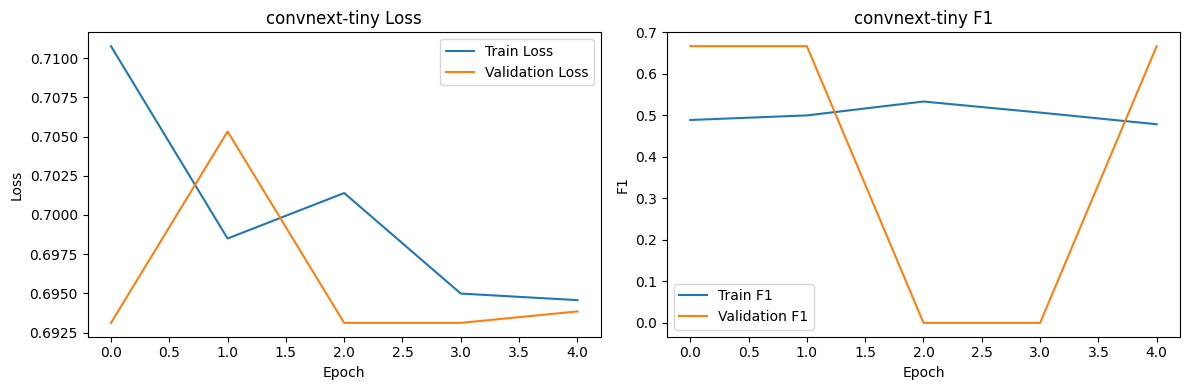

In [24]:
import matplotlib.pyplot as plt

for model_name in models_names:
    df = pd.read_csv(f"train_metrics/{model_name}_train_metrics.csv")
    train_df = df[df['Phase'] == 'train']
    val_df = df[df['Phase'] == 'validation']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_df['Epoch'], train_df['Loss'], label='Train Loss')
    plt.plot(val_df['Epoch'], val_df['Loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_df['Epoch'], train_df['F1'], label='Train F1')
    plt.plot(val_df['Epoch'], val_df['F1'], label='Validation F1')
    plt.title(f'{model_name} F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()

    plt.tight_layout()
    plt.show()